# Predict Air Pollution

#### Pedagogical objectives
- Prepare the data (for real)
- Further dig into Recurrent Neural Networks
- Stack multiple layers of RNNs

#### ML objective
- predict the **air pollution on the next day**
- given a sequence of weather features, such as the temperature, the pression, etc..
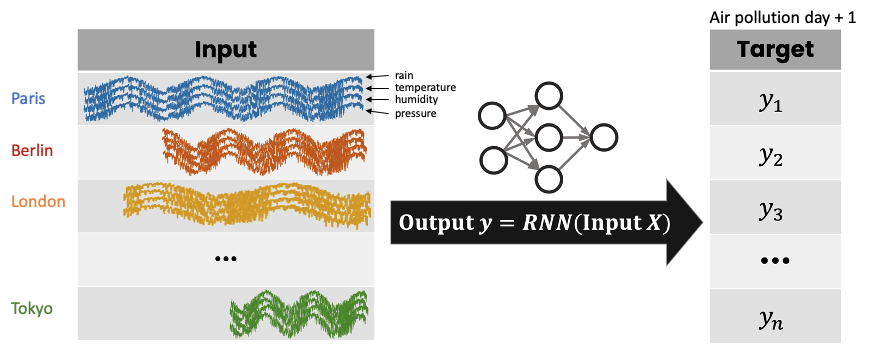

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 1. Preprocessing

### 1.1 Load and inspect data

In [51]:
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df.describe()

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,12.448521,1.817246,1016.447654,0.194916,0.052734,23.889140
std,92.050387,12.198613,14.433440,10.268698,1.415867,0.760375,50.010635
min,0.000000,-19.000000,-40.000000,991.000000,0.000000,0.000000,0.450000
25%,29.000000,2.000000,-10.000000,1008.000000,0.000000,0.000000,1.790000
50%,72.000000,14.000000,2.000000,1016.000000,0.000000,0.000000,5.370000
75%,137.000000,23.000000,15.000000,1025.000000,0.000000,0.000000,21.910000
max,994.000000,42.000000,28.000000,1046.000000,36.000000,27.000000,585.600000


☝️ The data here corresponds to hourly measurements of the air pollution (feature: `pm2.5`, which is the concentration of 2.5 millimeter particles) that you will try to predict. Among the other related features, you have:
- TEMP: Temperature
- DEWP: Dew Point
- PRES: Pressure
- Ir: Cumulated hours of rain
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow

❓ **Question** ❓ Plot the temporal progression of the different variables to get an intuition about the problem. How many years of data do we have? Are some feature visually correlated with the target?

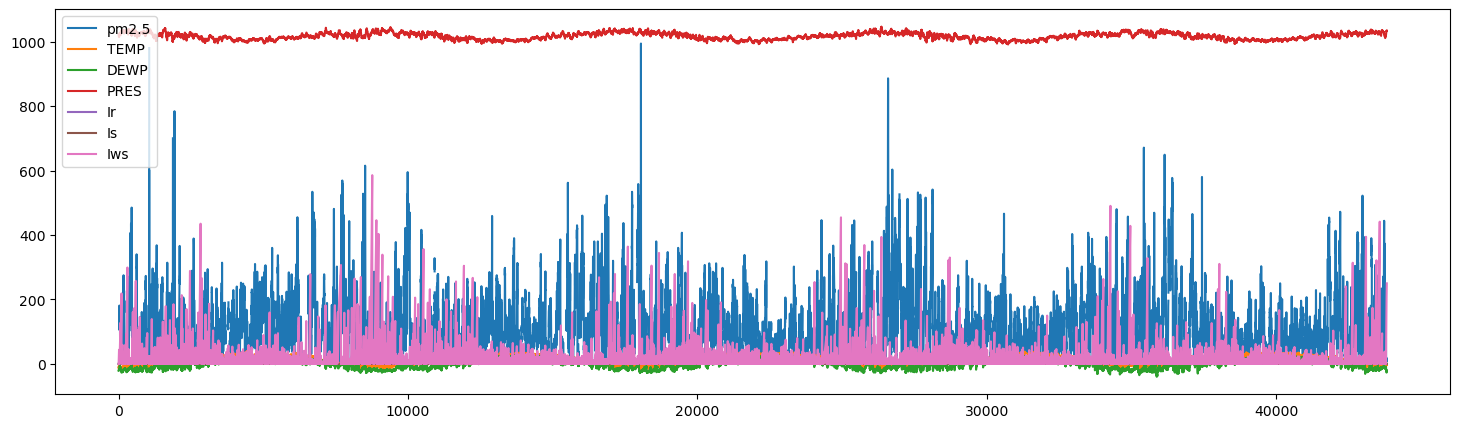

In [3]:
fig = plt.figure(1, figsize=(18, 5))
plt.plot(df)
plt.legend(df, loc = 'upper left')
plt.show()

In [4]:
years = round(43824/8760)
f"We have {years} years of data."

'We have 5 years of data.'

### 1.2 Create sequences (`X`,`y`) 

In the previous exercises, we had multiple independent data sequences. Here, you notice that there is only one. And this is quite often the case. So how to deal with such data? In fact, this long sequence can be separated in a lot of short sequences that we will consider as independent. 
![image.png](attachment:image.png)

This section aims to create a training set suitable for a RNN:
```python
X.shape = (n_sequences, length, n_features) # e.g. (100, 20, 7)
y.shape = (n_sequences, ) # e.g. (100,)
```

❓ **Question** ❓ Code the function `subsample_sequence` below such that it returns something like
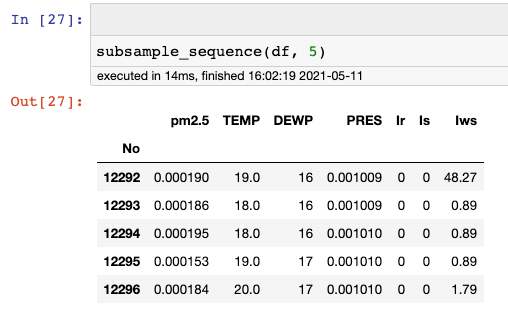

In [5]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    start_indice = np.random.choice(len(df)-length+1, replace=False)
    all_indices = [x for x in range(start_indice,start_indice+length)]
    df_sample = df.take(all_indices)
    return df_sample


In [6]:
# Test it 
assert subsample_sequence(df, 10).shape == (10, 7)
assert subsample_sequence(df, 40000).shape == (40000, 7)

❓ **Question** ❓ Write a function that given a full dataframe `df`:
- Subsamples this dataset into a shorter sequence of length `length`
- Stores the value of the pollution of the last day as your variable array `y`
- Stores all features of previous days as a variable `X`
- Returns (`X`, `y`)


In [7]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    df_sample = subsample_sequence(df, length)
    y_sample = df_sample.iloc[0+(length-1)][0]
    X_sample = df_sample.iloc[0:-1]
    
    return np.array(X_sample), np.array(y_sample)

In [8]:
# Test it
(X_sample, y_sample) = split_subsample_sequence(df, 10)
assert X_sample.shape == (9,7)
assert y_sample.shape == ()

🚨 There are missing values in the dataframe. Let's deal with it: 

- If the value to predict `y` is missing, the function should re-run.
- If there are missing values in the variables `X`, then it should be replaced by the mean values over the other selected hours. 
- If all the other hours are missing, then they should all be replaced by the mean value of the dataframe.

❓ **Question (HARD)** ❓ Try to update your function above taking this into account. Use the solution below if you don't find the answer.


<details>
    <summary>🆘  solution </summary>
    

```python
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)
```
</details>

In [9]:
#try to write the function by myself  
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    df_sample = subsample_sequence(df, length)
    y_sample = df_sample.iloc[0+(length-1)][0]
    X_sample = df_sample.iloc[0:-1]
    
    if y_sample == 'NaN' or y_sample == 'nan':
        split_subsample_sequence(df, lenght)
    
    X_sample = X_sample.fillna(X_sample.mean())
    
    
    return np.array(X_sample), np.array(y_sample)
    

In [10]:
# use of the given solution
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()

    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)

    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)

    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [11]:
(X_sample, y_sample) = split_subsample_sequence(df, 21)
X_sample.shape

(20, 7)

In [12]:
X_sample

array([[3.100e+02, 2.200e+01, 1.500e+01, 1.022e+03, 0.000e+00, 0.000e+00,
        3.130e+00],
       [2.980e+02, 2.200e+01, 1.500e+01, 1.021e+03, 0.000e+00, 0.000e+00,
        4.920e+00],
       [2.670e+02, 2.200e+01, 1.500e+01, 1.021e+03, 0.000e+00, 0.000e+00,
        8.050e+00],
       [2.610e+02, 2.200e+01, 1.500e+01, 1.020e+03, 0.000e+00, 0.000e+00,
        9.840e+00],
       [2.430e+02, 2.000e+01, 1.500e+01, 1.020e+03, 0.000e+00, 0.000e+00,
        1.163e+01],
       [2.630e+02, 1.800e+01, 1.500e+01, 1.020e+03, 0.000e+00, 0.000e+00,
        8.900e-01],
       [3.020e+02, 1.700e+01, 1.500e+01, 1.020e+03, 0.000e+00, 0.000e+00,
        1.790e+00],
       [3.310e+02, 1.800e+01, 1.500e+01, 1.021e+03, 0.000e+00, 0.000e+00,
        3.580e+00],
       [3.300e+02, 1.700e+01, 1.500e+01, 1.021e+03, 0.000e+00, 0.000e+00,
        5.370e+00],
       [3.080e+02, 1.500e+01, 1.400e+01, 1.021e+03, 0.000e+00, 0.000e+00,
        8.900e-01],
       [3.220e+02, 1.500e+01, 1.400e+01, 1.021e+03, 0.000e+0

❓ **Question** ❓ Write a last (!) function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [13]:
def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X = []
    y = []
    for sequence in range(n_sequences):
        
        (X_sample, y_sample) = split_subsample_sequence(df, length)
        X.append(X_sample)
        y.append(y_sample)
    
    X = np.array(X)
    y = np.array(y)
        
    return X, y

❓ **Question** ❓ Generate your dataset $(X, y)$ of `2000` sequences, each of `20` observations + the value of the pollution at the 21-st day to predict. That's about 40,000 observations, roughly equivalent to our dataset

In [14]:
X, y = get_X_y(df, 2000, 21)
X.shape

(2000, 20, 7)

In [15]:
# Check your code below
assert X.shape == (2000, 20, 7)
assert y.shape == (2000, )
assert np.isnan(X).sum() == 0

### 1.3 Train Test Split

🚨 **IMPORTANT REMARK: POTENTIAL DATA LEAKAGE** 🚨 If you split this dataset (X, y) into a training and a test set, it is much likely that some data in the train set are in the test set. Especially, you will predict data in test that are input data in train.

To avoid this situation, you should _first_ separate your initial dataframe `df` into a training dataframe and test dataframe as below

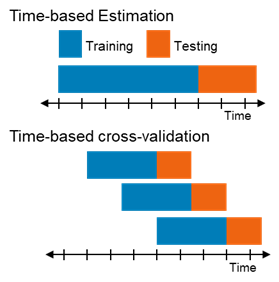


❓ **Question** ❓ Let's not cross-validate in this challenge to start with 🤯 
- Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training, and the last 20% in the test set.
- Then generate (`X_train`, `y_train`) from `df_train` and (`X_test`, `y_test`) from `df_test`
- Ensure that `X_train.shape == (2000, 20, 7)`

In [16]:
#test_size = int(20*len(df)/100)
#df_train = df[:-test_size]
#df_test = df[-test_size:]

In [17]:
#(X_train, y_train) = get_X_y(df_train, 2000, 21)
#(X_test, y_test) = get_X_y(df_train, 2000, 21)

In [45]:
def split_data(nb_sequences=2000, nb_days=21):
    test_size = int(20*len(df)/100)
    df_train = df[:-test_size]
    df_test = df[-test_size:]
    (X_train, y_train) = get_X_y(df_train, nb_sequences, nb_days)
    (X_test, y_test) = get_X_y(df_train, nb_sequences, nb_days)
    
    return X_train, y_train, X_test, y_test
    

In [47]:
X_train, y_train, X_test, y_test = split_data()

In [48]:
assert X_train.shape == (2000, 20, 7)

## 2. Predict pollution !

❓ **Question** ❓ First, what is your benchmark prediction to beat?  
Let's measure our performance in terms of *Mean Absolute Percentage Error (MAPE)* for this Time Serie challenge!

In [19]:
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape


### 2.1 Simple LSTM

❓ **Question** ❓ Now, let's try here with a simple single-layer `LSTM`

- Initialize a model the way you want and compile it within the `init_model` function.
- Then, **Fit** your model and evaluate it on the test data using the `mape` metric (useful in time series)

💡 Pro tips:
- Look at the scale of your feature: Scale them features if needed
- Look at the scale of your target: If smaller than usual, increase the learning rate vs. default values!
- Don't forget to plot your loss history to get visual feedback

In [67]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def init_model(X_train):

    model = Sequential()
    model.add(LSTM(10,input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae',optimizer='adam')
    return model
  

In [21]:
model = init_model(X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                720       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


2023-03-22 15:25:08.664148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
es = EarlyStopping(patience=5)
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,  
    verbose=1,
    batch_size=32, callbacks=[es])

Epoch 1/100
50/50 [==============================] - 1s 11ms/step - loss: 102.2858 - val_loss: 103.7895
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 101.8219 - val_loss: 103.4246
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 101.3991 - val_loss: 103.0626
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 101.1510 - val_loss: 102.8478
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 100.9362 - val_loss: 102.6332
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 100.7215 - val_loss: 102.4187
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 100.5070 - val_loss: 102.2042
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 100.2926 - val_loss: 101.9897
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 100.0782 - val_loss: 101.7753
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss

50/50 [==============================] - 0s 5ms/step - loss: 86.7023 - val_loss: 88.0640
Epoch 82/100
50/50 [==============================] - 0s 5ms/step - loss: 86.5667 - val_loss: 87.9123
Epoch 83/100
50/50 [==============================] - 0s 5ms/step - loss: 86.4302 - val_loss: 87.7599
Epoch 84/100
50/50 [==============================] - 0s 4ms/step - loss: 86.2935 - val_loss: 87.6109
Epoch 85/100
50/50 [==============================] - 0s 4ms/step - loss: 86.1640 - val_loss: 87.4673
Epoch 86/100
50/50 [==============================] - 0s 4ms/step - loss: 86.0358 - val_loss: 87.3236
Epoch 87/100
50/50 [==============================] - 0s 4ms/step - loss: 85.9070 - val_loss: 87.1780
Epoch 88/100
50/50 [==============================] - 0s 4ms/step - loss: 85.7773 - val_loss: 87.0324
Epoch 89/100
50/50 [==============================] - 0s 4ms/step - loss: 85.6469 - val_loss: 86.8860
Epoch 90/100
50/50 [==============================] - 0s 4ms/step - loss: 85.5185 - val_loss: 8

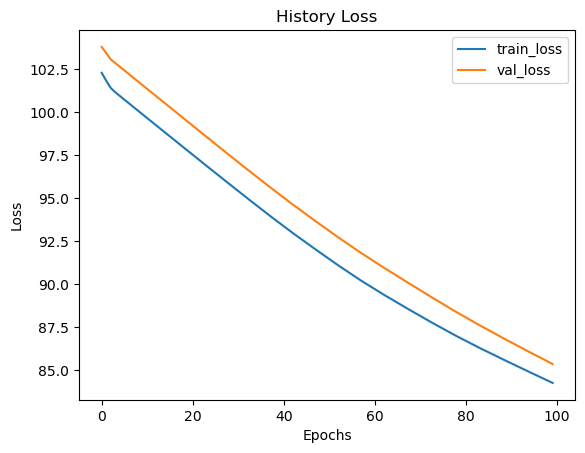

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('History Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(X_test)

print(MAPE(y_test, y_pred))

63/63 [==============================] - 0s 1ms/step
70.43681748428145


### 2.3 Stack RNN layers

❓ **Question** ❓ Now that you know how to write a recurrent architecture, let's see how to stack one.
If you want to stack multiple RNN, LSTM, GRU layers, it is very easy. Do it as if they were Dense (or any other) layers.

But don't forget: All RNN (**EXCEPT** the last one) should have the `return_sequences` set to True so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

In [77]:
from keras.metrics import MeanAbsolutePercentageError
def init_model(X_train):
    es = EarlyStopping(patience=5)
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=False))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae',optimizer='adam', metrics=[MeanAbsolutePercentageError()])
    return model

In [78]:
model = init_model(X_train)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 20, 64)            18432     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    validation_split=0.2,  
    verbose=1,
    batch_size=500, callbacks=[es])

Epoch 1/500
4/4 [==============================] - 3s 244ms/step - loss: 97.2695 - mean_absolute_percentage_error: 99.9720 - val_loss: 96.7671 - val_mean_absolute_percentage_error: 99.5425
Epoch 2/500
4/4 [==============================] - 0s 50ms/step - loss: 96.9543 - mean_absolute_percentage_error: 99.0309 - val_loss: 96.2112 - val_mean_absolute_percentage_error: 98.0764
Epoch 3/500
4/4 [==============================] - 0s 51ms/step - loss: 96.4250 - mean_absolute_percentage_error: 97.4277 - val_loss: 95.7127 - val_mean_absolute_percentage_error: 96.7376
Epoch 4/500
4/4 [==============================] - 0s 55ms/step - loss: 95.9300 - mean_absolute_percentage_error: 96.0412 - val_loss: 95.2132 - val_mean_absolute_percentage_error: 95.4276
Epoch 5/500
4/4 [==============================] - 0s 68ms/step - loss: 95.4270 - mean_absolute_percentage_error: 94.5956 - val_loss: 94.6995 - val_mean_absolute_percentage_error: 94.0736
Epoch 6/500
4/4 [==============================] - 0s 73ms/

4/4 [==============================] - 0s 82ms/step - loss: 72.4517 - mean_absolute_percentage_error: 86.7993 - val_loss: 70.6987 - val_mean_absolute_percentage_error: 77.7661
Epoch 45/500
4/4 [==============================] - 0s 79ms/step - loss: 72.0342 - mean_absolute_percentage_error: 86.5954 - val_loss: 70.1982 - val_mean_absolute_percentage_error: 77.6672
Epoch 46/500
4/4 [==============================] - 0s 81ms/step - loss: 71.6113 - mean_absolute_percentage_error: 85.7035 - val_loss: 69.8456 - val_mean_absolute_percentage_error: 78.6942
Epoch 47/500
4/4 [==============================] - 0s 82ms/step - loss: 71.3170 - mean_absolute_percentage_error: 88.6398 - val_loss: 69.4054 - val_mean_absolute_percentage_error: 79.2030
Epoch 48/500
4/4 [==============================] - 0s 91ms/step - loss: 70.8756 - mean_absolute_percentage_error: 87.9191 - val_loss: 69.0597 - val_mean_absolute_percentage_error: 79.2001
Epoch 49/500
4/4 [==============================] - 0s 100ms/step - 

4/4 [==============================] - 0s 80ms/step - loss: 46.9179 - mean_absolute_percentage_error: 42.6161 - val_loss: 45.8099 - val_mean_absolute_percentage_error: 45.6607
Epoch 88/500
4/4 [==============================] - 0s 78ms/step - loss: 46.4152 - mean_absolute_percentage_error: 43.2570 - val_loss: 45.4224 - val_mean_absolute_percentage_error: 43.9889
Epoch 89/500
4/4 [==============================] - 0s 74ms/step - loss: 45.9029 - mean_absolute_percentage_error: 41.4320 - val_loss: 44.7488 - val_mean_absolute_percentage_error: 44.4213
Epoch 90/500
4/4 [==============================] - 0s 73ms/step - loss: 45.4629 - mean_absolute_percentage_error: 41.4210 - val_loss: 44.5045 - val_mean_absolute_percentage_error: 44.6112
Epoch 91/500
4/4 [==============================] - 0s 72ms/step - loss: 45.0859 - mean_absolute_percentage_error: 42.2214 - val_loss: 44.4213 - val_mean_absolute_percentage_error: 43.1762
Epoch 92/500
4/4 [==============================] - 0s 77ms/step - l

4/4 [==============================] - 0s 88ms/step - loss: 30.8269 - mean_absolute_percentage_error: 29.5913 - val_loss: 29.6328 - val_mean_absolute_percentage_error: 31.3597
Epoch 131/500
4/4 [==============================] - 0s 73ms/step - loss: 30.5674 - mean_absolute_percentage_error: 29.6318 - val_loss: 29.5064 - val_mean_absolute_percentage_error: 30.8479
Epoch 132/500
4/4 [==============================] - 0s 73ms/step - loss: 30.3868 - mean_absolute_percentage_error: 29.2852 - val_loss: 29.1128 - val_mean_absolute_percentage_error: 30.4356
Epoch 133/500
4/4 [==============================] - 0s 79ms/step - loss: 30.1240 - mean_absolute_percentage_error: 28.6556 - val_loss: 28.9340 - val_mean_absolute_percentage_error: 32.0431
Epoch 134/500
4/4 [==============================] - 0s 80ms/step - loss: 29.9432 - mean_absolute_percentage_error: 30.3195 - val_loss: 28.7720 - val_mean_absolute_percentage_error: 30.2492
Epoch 135/500
4/4 [==============================] - 0s 75ms/ste

4/4 [==============================] - 0s 81ms/step - loss: 22.8393 - mean_absolute_percentage_error: 24.1291 - val_loss: 21.4178 - val_mean_absolute_percentage_error: 25.1073
Epoch 174/500
4/4 [==============================] - 0s 77ms/step - loss: 22.8507 - mean_absolute_percentage_error: 25.1325 - val_loss: 21.2895 - val_mean_absolute_percentage_error: 24.0958
Epoch 175/500
4/4 [==============================] - 0s 80ms/step - loss: 22.7932 - mean_absolute_percentage_error: 24.4453 - val_loss: 21.2665 - val_mean_absolute_percentage_error: 26.2449
Epoch 176/500
4/4 [==============================] - 0s 78ms/step - loss: 22.6578 - mean_absolute_percentage_error: 25.2431 - val_loss: 21.5635 - val_mean_absolute_percentage_error: 24.6347
Epoch 177/500
4/4 [==============================] - 0s 75ms/step - loss: 22.6787 - mean_absolute_percentage_error: 25.1233 - val_loss: 21.4681 - val_mean_absolute_percentage_error: 26.4560
Epoch 178/500
4/4 [==============================] - 0s 74ms/ste

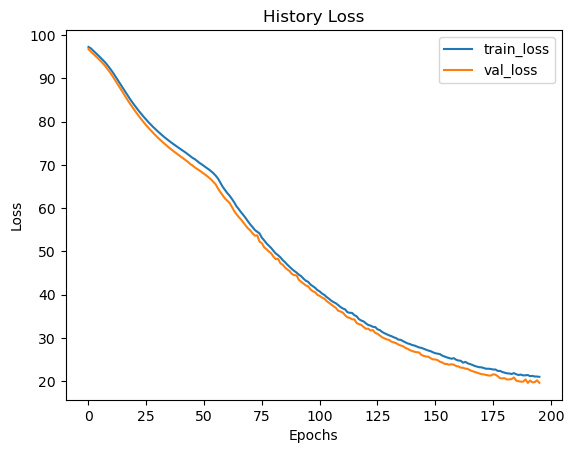

In [80]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('History Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
y_pred = model.predict(X_test)

MAPE(y_test, y_pred)

63/63 [==============================] - 0s 4ms/step


203.8229748018496

## 3.  Check effect of data size on performance

❓ **Question** ❓ Now, let's see how the performance changes depending on

- the number of days in each sequence (20+1 days in the previous example).
- the number of sequences (2000 sequences in our previous example)

For different values of temporal sequence lengths, re-split your data, run your model and evaluate its performance. We advise to wrap this analysis into the function below

In [85]:
def train_model(nb_sequences=1000, nb_days=21, plot_history=False):
    '''returns the MAPE on the train set'''
    # split data
    X_train, y_train, X_test, y_test = split_data(nb_sequences, nb_days)
    # init model
    model = init_model(X_train)
    # train model
    history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=1, batch_size=128, callbacks=[es])
    # predict data
    y_pred = model.predict(X_test)
    # evaluate model
    result = MAPE(y_test, y_pred)
    return result
    
    

In [86]:
train_model(2000, 50)

Epoch 1/500
13/13 [==============================] - 4s 97ms/step - loss: 95.8350 - mean_absolute_percentage_error: 96.8909 - val_loss: 90.4283 - val_mean_absolute_percentage_error: 95.0143
Epoch 2/500
13/13 [==============================] - 1s 51ms/step - loss: 94.4688 - mean_absolute_percentage_error: 93.2548 - val_loss: 88.9757 - val_mean_absolute_percentage_error: 91.0658
Epoch 3/500
13/13 [==============================] - 1s 52ms/step - loss: 92.8693 - mean_absolute_percentage_error: 88.9133 - val_loss: 87.1730 - val_mean_absolute_percentage_error: 86.1663
Epoch 4/500
13/13 [==============================] - 1s 52ms/step - loss: 90.9456 - mean_absolute_percentage_error: 84.1403 - val_loss: 85.0840 - val_mean_absolute_percentage_error: 80.7866
Epoch 5/500
13/13 [==============================] - 1s 52ms/step - loss: 88.8341 - mean_absolute_percentage_error: 79.3479 - val_loss: 82.8821 - val_mean_absolute_percentage_error: 75.5491
Epoch 6/500
13/13 [==============================]

146.2341051671399